In [1]:
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_networkx

import torch.nn.functional as F
import torch.nn as nn
import torch


import networkx as nx

import matplotlib.pyplot as plt

import random

In [2]:
# https://towardsdatascience.com/graph-neural-networks-with-pyg-on-node-classification-link-prediction-and-anomaly-detection-14aa38fe1275

In [3]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
graph = dataset[0]
graph

Processing...
Done!


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

/var/folders/bj/dl04dyqj0zb3yqggq2_t15240000gn/T/ipykernel_79144/2664274811.py:7: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  sampled_nodes = random.sample(g.nodes, n_sample)


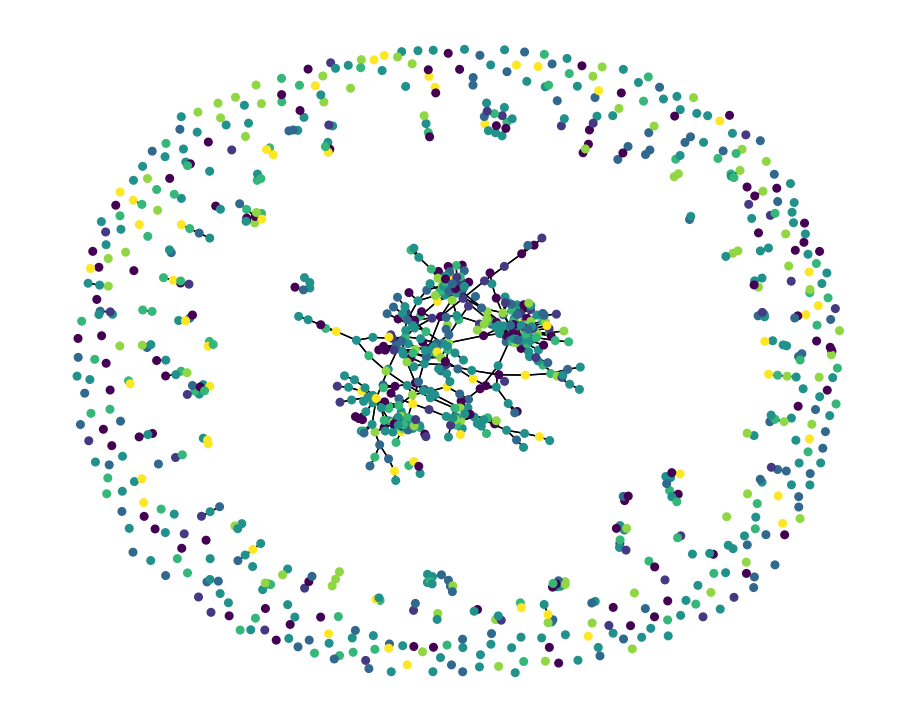

In [4]:
def convert_to_networkx(graph, n_sample=None):

    g = to_networkx(graph, node_attrs=["x"])
    y = graph.y.numpy()

    if n_sample is not None:
        sampled_nodes = random.sample(g.nodes, n_sample)
        g = g.subgraph(sampled_nodes)
        y = y[sampled_nodes]

    return g, y


def plot_graph(g, y):

    plt.figure(figsize=(9, 7))
    nx.draw_spring(g, node_size=30, arrows=False, node_color=y)
    plt.show() 
    
    
g, y = convert_to_networkx(graph, n_sample=1000)
plot_graph(g, y)

In [5]:
split = T.RandomNodeSplit(num_val=0.1, num_test=0.2)
graph = split(graph)
graph

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [6]:
def train_node_classifier(model, graph, optimizer, criterion, n_epochs=200):

    for epoch in range(1, n_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(graph)
        loss = criterion(out[graph.train_mask], graph.y[graph.train_mask])
        loss.backward()
        optimizer.step()

        pred = out.argmax(dim=1)
        acc = eval_node_classifier(model, graph, graph.val_mask)

        if epoch % 10 == 0:
            print(f'Epoch: {epoch:03d}, Train Loss: {loss:.3f}, Val Acc: {acc:.3f}')

    return model

def eval_node_classifier(model, graph, mask):
    model.eval()
    pred = model(graph).argmax(dim=1)
    correct = (pred[mask] == graph.y[mask]).sum()
    acc = int(correct) / int(mask.sum())

    return acc

In [7]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        output = self.conv2(x, edge_index)

        return output
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gcn = GCN().to(device)
optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()
gcn = train_node_classifier(gcn, graph, optimizer_gcn, criterion)

test_acc = eval_node_classifier(gcn, graph, graph.test_mask)
print(f'Test Acc: {test_acc:.3f}')

Epoch: 010, Train Loss: 1.022, Val Acc: 0.727
Epoch: 020, Train Loss: 0.461, Val Acc: 0.875
Epoch: 030, Train Loss: 0.255, Val Acc: 0.897
Epoch: 040, Train Loss: 0.184, Val Acc: 0.886
Epoch: 050, Train Loss: 0.152, Val Acc: 0.886
Epoch: 060, Train Loss: 0.136, Val Acc: 0.886
Epoch: 070, Train Loss: 0.126, Val Acc: 0.886
Epoch: 080, Train Loss: 0.117, Val Acc: 0.893
Epoch: 090, Train Loss: 0.109, Val Acc: 0.886
Epoch: 100, Train Loss: 0.101, Val Acc: 0.889
Epoch: 110, Train Loss: 0.095, Val Acc: 0.893
Epoch: 120, Train Loss: 0.090, Val Acc: 0.889
Epoch: 130, Train Loss: 0.086, Val Acc: 0.886
Epoch: 140, Train Loss: 0.082, Val Acc: 0.886
Epoch: 150, Train Loss: 0.079, Val Acc: 0.878
Epoch: 160, Train Loss: 0.076, Val Acc: 0.878
Epoch: 170, Train Loss: 0.073, Val Acc: 0.878
Epoch: 180, Train Loss: 0.071, Val Acc: 0.878
Epoch: 190, Train Loss: 0.069, Val Acc: 0.878
Epoch: 200, Train Loss: 0.067, Val Acc: 0.878
Test Acc: 0.873


In [8]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        output = self.conv2(x, edge_index)

        return output

gcn = GCN().to(device)
gcn(graph), graph.y

(tensor([[ 0.0426,  0.0352,  0.0306,  ..., -0.0327,  0.0308,  0.0872],
         [ 0.1666,  0.0673,  0.0052,  ..., -0.1054,  0.0580,  0.0866],
         [ 0.1233,  0.0677, -0.0259,  ..., -0.1110,  0.0476,  0.1069],
         ...,
         [ 0.0587,  0.0608, -0.0933,  ..., -0.0434, -0.0503, -0.0185],
         [ 0.0703,  0.0732, -0.0623,  ..., -0.1276, -0.0103,  0.1663],
         [ 0.0812,  0.0691, -0.0936,  ..., -0.1300, -0.0163,  0.1357]],
        grad_fn=<AddBackward0>),
 tensor([3, 4, 4,  ..., 3, 3, 3]))